# Import

In [1]:
import re
import ast
import pandas as pd
import requests
import numpy as np
import json
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *

# CMU DATASET ANALYSIS

In [2]:
DATA_FOLDER = './datasets/'

In [3]:
# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB',
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name',
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER+'CMU_dataset/character.metadata.tsv', names=columns_char,
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

# Loading movies
columns_mov = ['Wikipedia_Movie_ID','Freebase_Movie_ID','Movie_name','Movie_release_date',
          'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
          'Movie_genres']

cmu_df = pd.read_table(DATA_FOLDER+'CMU_dataset/movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

The goal of our study is to analyze what factors contribute to the succeess of a movie. Let us first have a quick analysis on our provided data set.


DataFrame Shape: (81741, 9)

Data Types Counts:
object     6
float64    2
int64      1
Name: count, dtype: int64


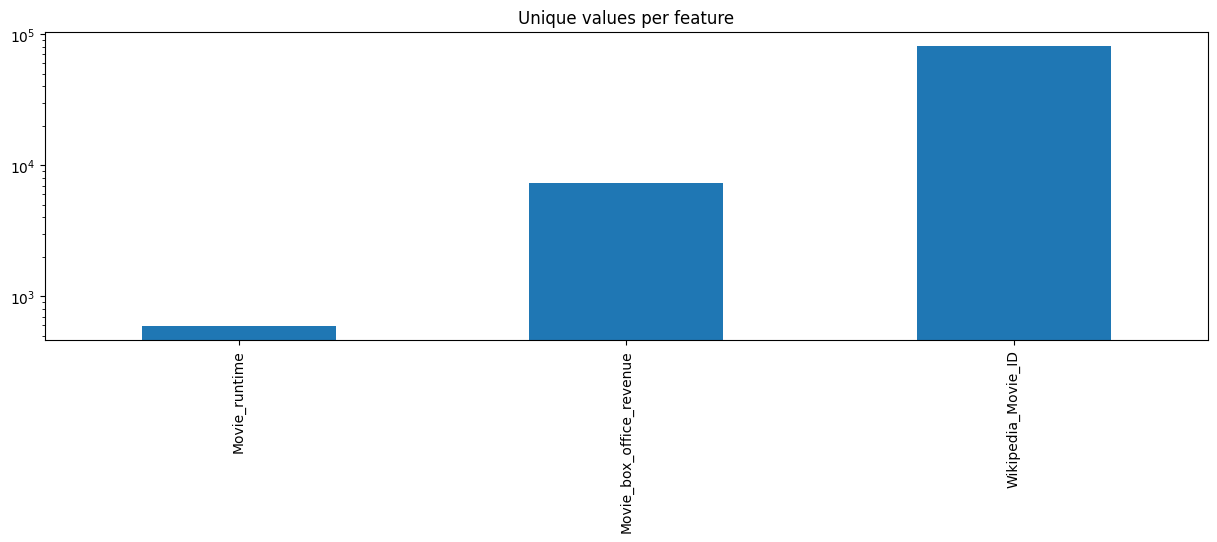

In [4]:
structural_analysis (cmu_df)

DataFrame Shape: (450669, 10)

Data Types Counts:
object     7
float64    2
int64      1
Name: count, dtype: int64


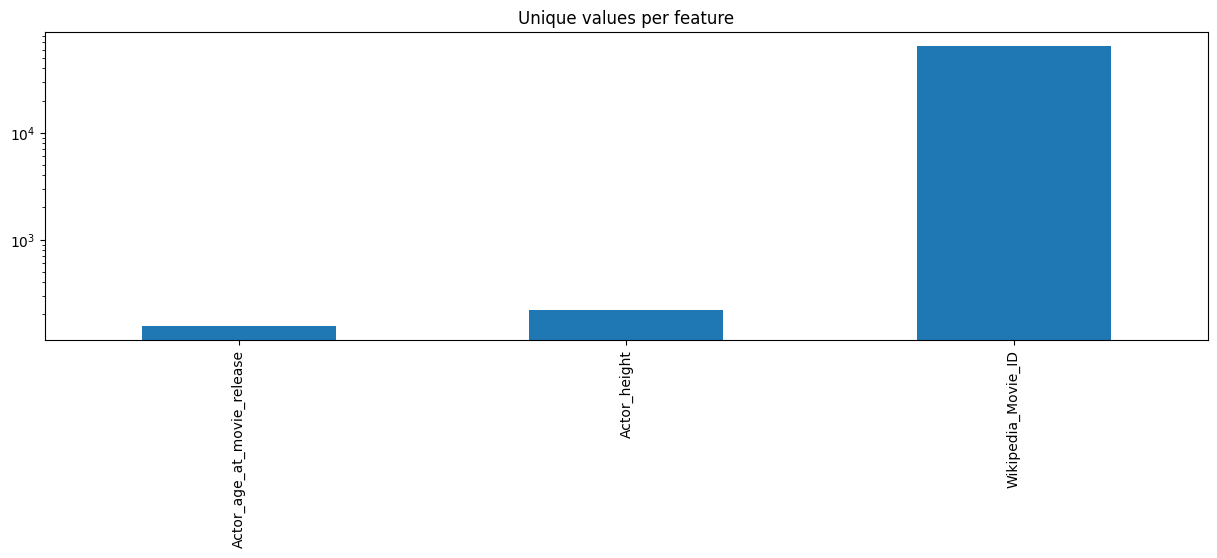

In [5]:
structural_analysis(characters)

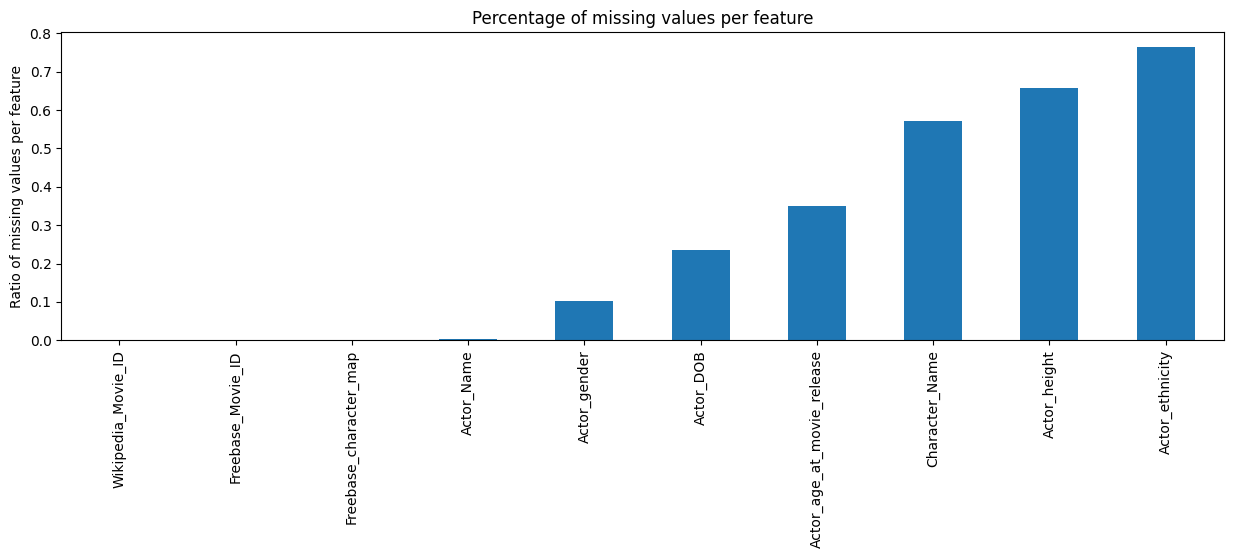

In [6]:
plot_missing_values_percenatage(characters)

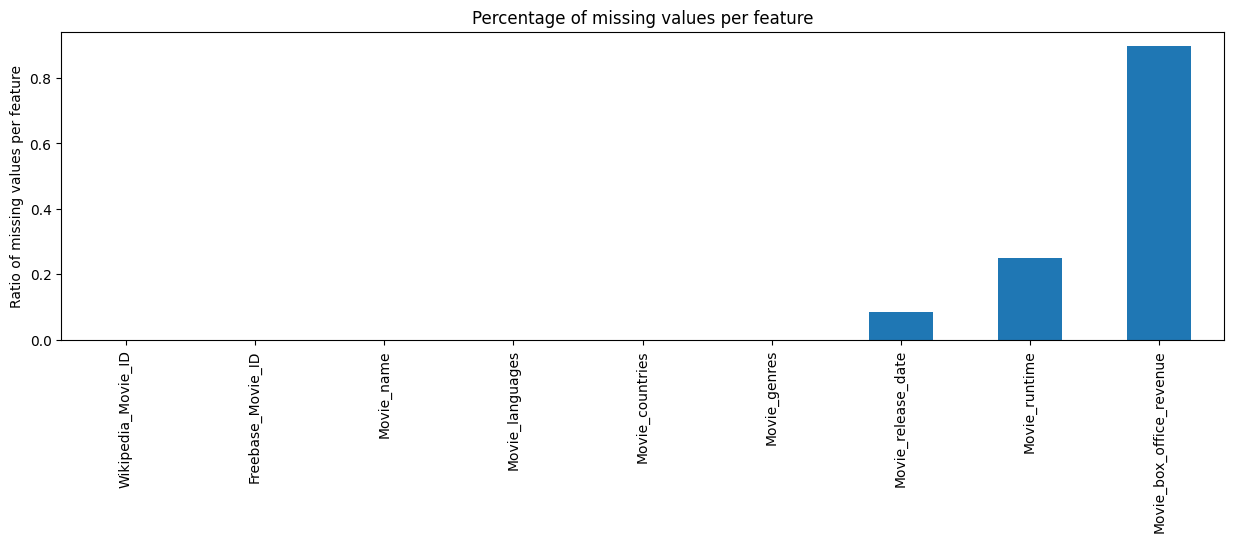

In [7]:
plot_missing_values_percenatage(cmu_df)

Good factors to measure the success of a movie are it's ratings and it's revenues. We can see that our data set does not contain any information on movie ratings, and has a very high percentage of missing values for the movie revenues.

### Creating a mapping between the IMDB Id and the Freebase_Movie_ID

In [8]:
def query_wikidata():
    url = 'https://query.wikidata.org/sparql'
    query = """
    SELECT ?item ?imdb ?freebase WHERE {
      ?item wdt:P345 ?imdb.
      ?item wdt:P646 ?freebase.
    }
    """
    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()
    return data

In [9]:
data = query_wikidata()

In [10]:
def json_to_df(data):
    imdb_ids = []
    freebase_ids = []
    for item in data['results']['bindings']:
        imdb_ids.append(item['imdb']['value'])
        freebase_ids.append(item['freebase']['value'])
    df = pd.DataFrame({'imdb_id': imdb_ids, 'freebase_id': freebase_ids})
    return df

In [11]:
imbd_freebase = json_to_df(data)

In [12]:
imbd_freebase.drop_duplicates(subset=['imdb_id','freebase_id'], inplace=True)

# 2. TMBD Analysis

In [13]:
pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')
pd_tmbd

/var/folders/c6/1b0lb_gj5sscv1_rt1p35drm0000gn/T/ipykernel_8893/3871895761.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


### Drop Non-related Columns

In [14]:
pd_tmbd = pd_tmbd.drop(['adult', 'belongs_to_collection',  'homepage', 'original_title', 'overview', 'poster_path', 'status', 'tagline', 'video'], axis=1)
pd_tmbd

,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0
4,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,tt6209470,fa,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Subdue,4.0,1.0
45462,0,"[{'id': 18, 'name': 'Drama'}]",111109,tt2028550,tl,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Century of Birthing,9.0,3.0
45463,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,tt0303758,en,0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Betrayal,3.8,6.0
45464,0,[],227506,tt0008536,en,0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],Satan Triumphant,0.0,0.0


In [15]:
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except ValueError:
        return []


def get_names(x):
    try:
        result = []
        for d in x:
            result.append(d['name'])
        return result
    except TypeError:
        return []


#### Evaluate the literal value to convert it to array

In [16]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: safe_literal_eval(x))

#### Convert the initial dictonnaries into array of items

In [17]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: get_names(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: get_names(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: get_names(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: get_names(x))

### Merging the CMU and the TMDB Datasets

In [18]:
cmu_df = pd.merge(left=cmu_df, right=imbd_freebase, right_on='freebase_id', left_on='Freebase_Movie_ID', how='inner').drop(columns='freebase_id')

In [19]:
movies = pd.merge(right=cmu_df, left=pd_tmbd, on='imdb_id', how='inner').drop_duplicates(subset='imdb_id')

### Box Office Revenue Data Consolidation

In [20]:
movies['revenue'].replace(0.0, np.nan, inplace=True)
movies['Movie_box_office_revenue'].replace(0.0, np.nan, inplace=True)

In [21]:
movies['revenue'] = movies['revenue'].fillna(movies['Movie_box_office_revenue'])
movies['Movie_box_office_revenue'] = movies['Movie_box_office_revenue'].fillna(movies['revenue'])
movies.drop(columns='revenue', inplace=True)

In [22]:
movies = movies.dropna(subset=['Movie_box_office_revenue'])

### Preprocessing the columns

In [23]:
def transform_row(row):
    res = list(json.loads(row).values())
    return res

In [24]:
movies['Movie_genres'] = movies['Movie_genres'].apply(transform_row)
movies['Movie_countries'] = movies['Movie_countries'].apply(transform_row)
movies['Movie_languages'] = movies['Movie_languages'].apply(transform_row)

In [25]:
movies.drop(columns=['Wikipedia_Movie_ID', 'Freebase_Movie_ID','Movie_release_date', 'title', 'runtime', 'original_language', 'production_companies','id'], axis=1, inplace=True)

Now that we have our merged data set, let us run a data exploratory analysis on it.

DataFrame Shape: (9146, 15)

Data Types Counts:
object     11
float64     4
Name: count, dtype: int64


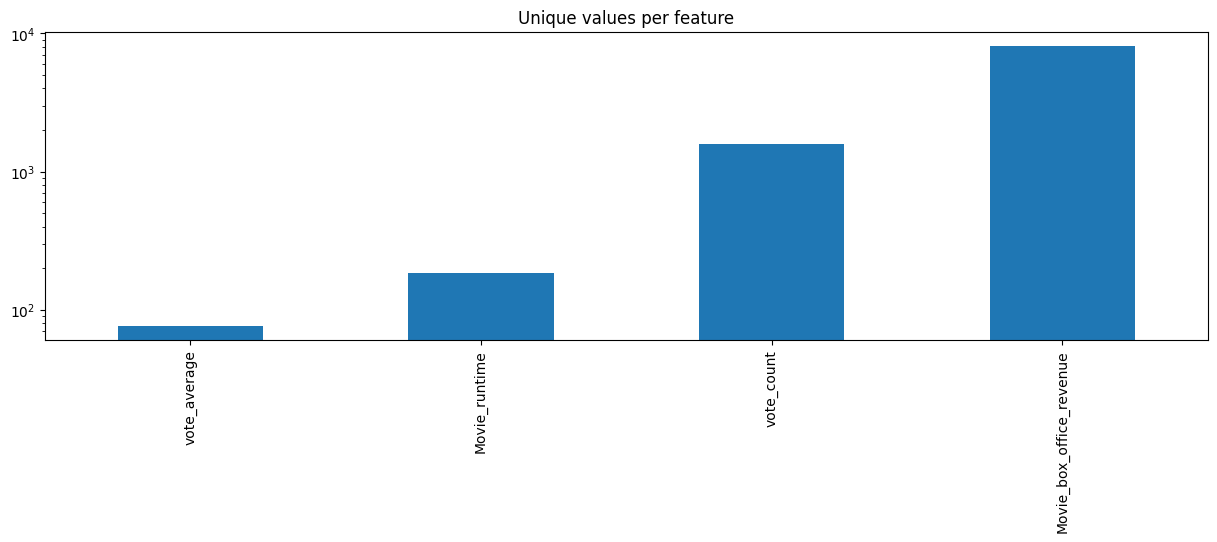

In [26]:
structural_analysis(movies)

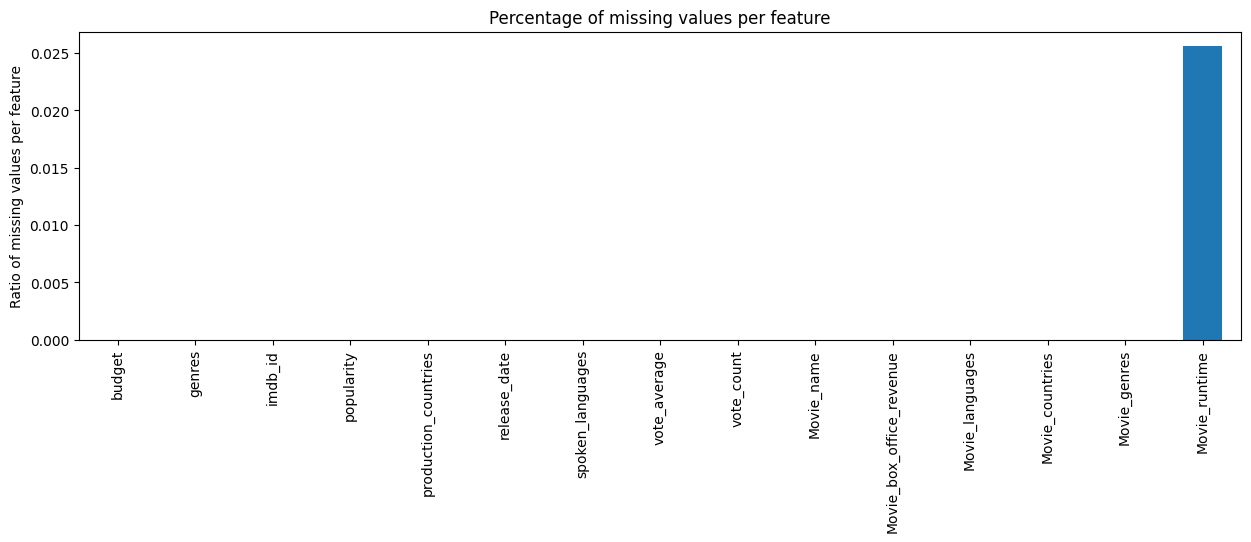

In [27]:
plot_missing_values_percenatage(movies)

We can see that we have now features describing the movie success as the revenue and ratings.

In [28]:
movies.head()

,budget,genres,imdb_id,popularity,production_countries,release_date,spoken_languages,vote_average,vote_count,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,30000000,"[Animation, Comedy, Family]",tt0114709,21.946943,[United States of America],1995-10-30,[English],7.7,5415.0,Toy Story,361958736.0,77.0,[English Language],[United States of America],"[Buddy film, Adventure, Children's/Family, Com..."
1,65000000,"[Adventure, Fantasy, Family]",tt0113497,17.015539,[United States of America],1995-12-15,"[English, Français]",6.9,2413.0,Jumanji,262797249.0,104.0,"[French Language, English Language]","[United States of America, Japan]","[Thriller, Fantasy Adventure, Japanese Movies,..."
2,0,"[Romance, Comedy]",tt0113228,11.7129,[United States of America],1995-12-22,[English],6.5,92.0,Grumpier Old Men,71518503.0,101.0,"[Italian Language, English Language]",[United States of America],"[Romantic comedy, Buddy film, Comedy]"
3,16000000,"[Comedy, Drama, Romance]",tt0114885,3.859495,[United States of America],1995-12-22,[English],6.1,34.0,Waiting to Exhale,81452156.0,121.0,[English Language],[United States of America],"[Ensemble Film, Female buddy film, Comedy-dram..."
4,0,[Comedy],tt0113041,8.387519,[United States of America],1995-02-10,[English],5.7,173.0,Father of the Bride Part II,76594107.0,106.0,[English Language],[United States of America],"[Screwball comedy, Romance Film, Family Film, ..."


Columns such as budget and popularity do not have the good type, we can quickly fix  this.


In [29]:
movies['popularity'] = movies['popularity'].astype(float)
movies['budget'] = movies['budget'].astype(float)


Let us now plot the distribution of the continuous values for each of the continuous features of the movies dataframe.

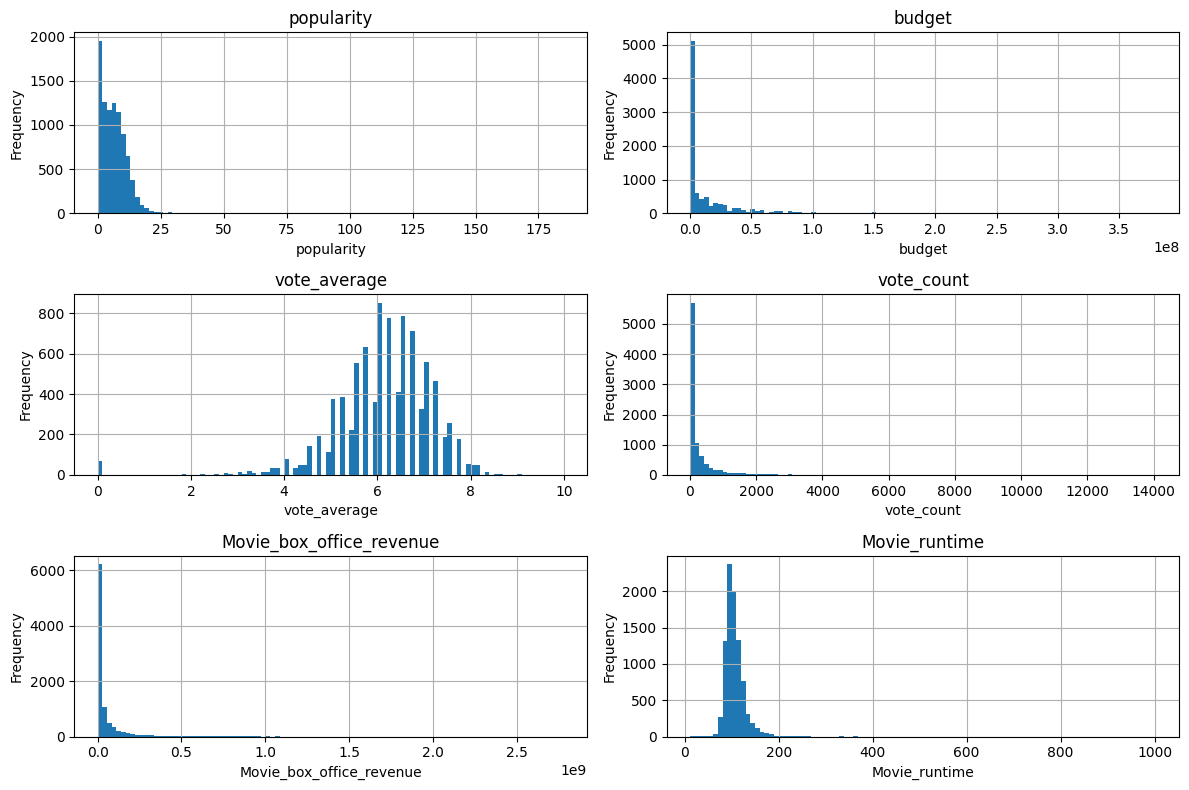

In [30]:
plot_histograms(movies, ['popularity', 'budget','vote_average','vote_count','Movie_box_office_revenue','Movie_runtime'])

To work with release dates in a more convenient way, let us split the column into two columns, each for the release year and the release month.

In [31]:
split_date(movies, movies['release_date'])

movies.head()

,budget,genres,imdb_id,popularity,production_countries,spoken_languages,vote_average,vote_count,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,30000000.0,"[Animation, Comedy, Family]",tt0114709,21.946943,[United States of America],[English],7.7,5415.0,Toy Story,361958736.0,77.0,[English Language],[United States of America],"[Buddy film, Adventure, Children's/Family, Com...",1995,10
1,65000000.0,"[Adventure, Fantasy, Family]",tt0113497,17.015539,[United States of America],"[English, Français]",6.9,2413.0,Jumanji,262797249.0,104.0,"[French Language, English Language]","[United States of America, Japan]","[Thriller, Fantasy Adventure, Japanese Movies,...",1995,12
2,0.0,"[Romance, Comedy]",tt0113228,11.712900,[United States of America],[English],6.5,92.0,Grumpier Old Men,71518503.0,101.0,"[Italian Language, English Language]",[United States of America],"[Romantic comedy, Buddy film, Comedy]",1995,12
3,16000000.0,"[Comedy, Drama, Romance]",tt0114885,3.859495,[United States of America],[English],6.1,34.0,Waiting to Exhale,81452156.0,121.0,[English Language],[United States of America],"[Ensemble Film, Female buddy film, Comedy-dram...",1995,12
4,0.0,[Comedy],tt0113041,8.387519,[United States of America],[English],5.7,173.0,Father of the Bride Part II,76594107.0,106.0,[English Language],[United States of America],"[Screwball comedy, Romance Film, Family Film, ...",1995,02


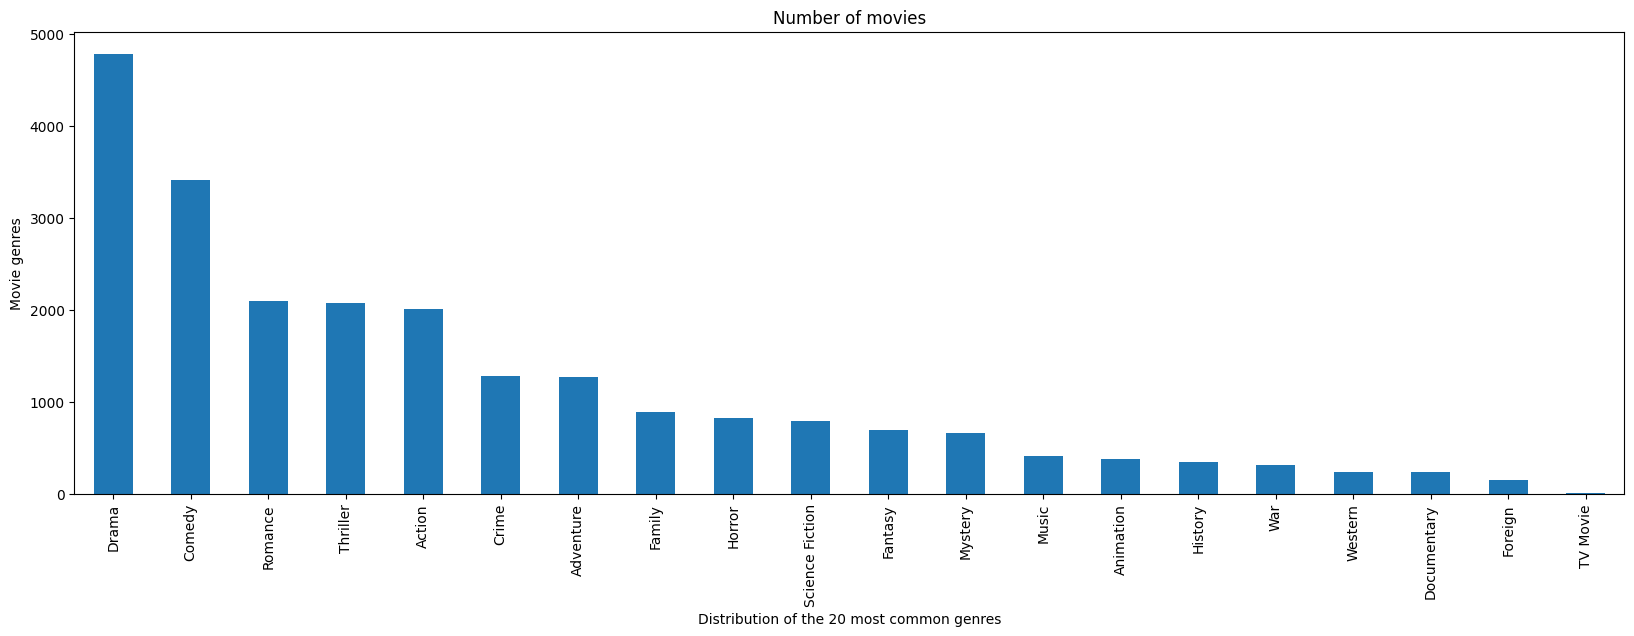

In [32]:

plot_top_20_most_popular(movies, 'genres','Distribution of the 20 most common genres','Movie genres','Number of movies')

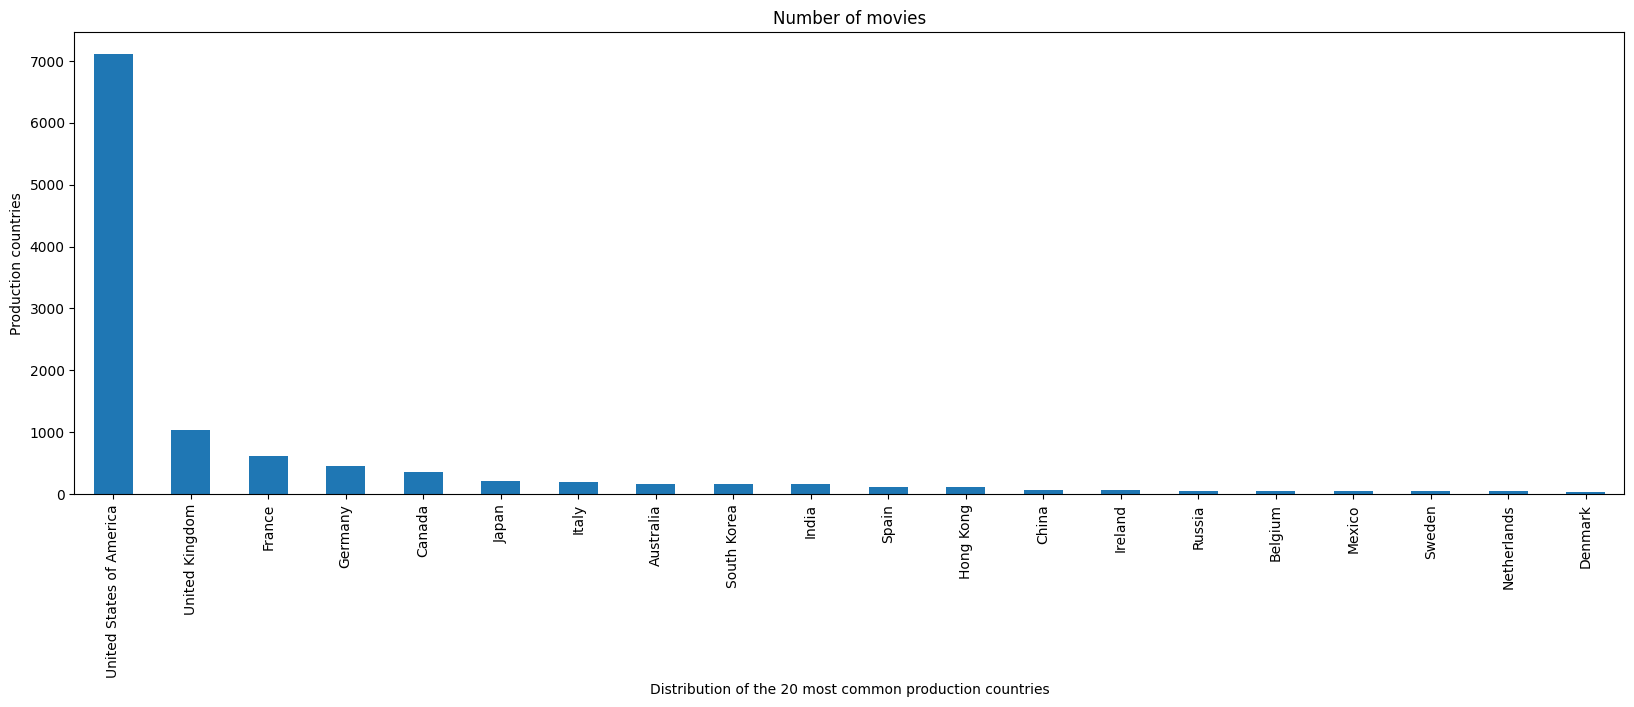

In [33]:
plot_top_20_most_popular(movies, 'production_countries','Distribution of the 20 most common production countries','Production countries','Number of movies')

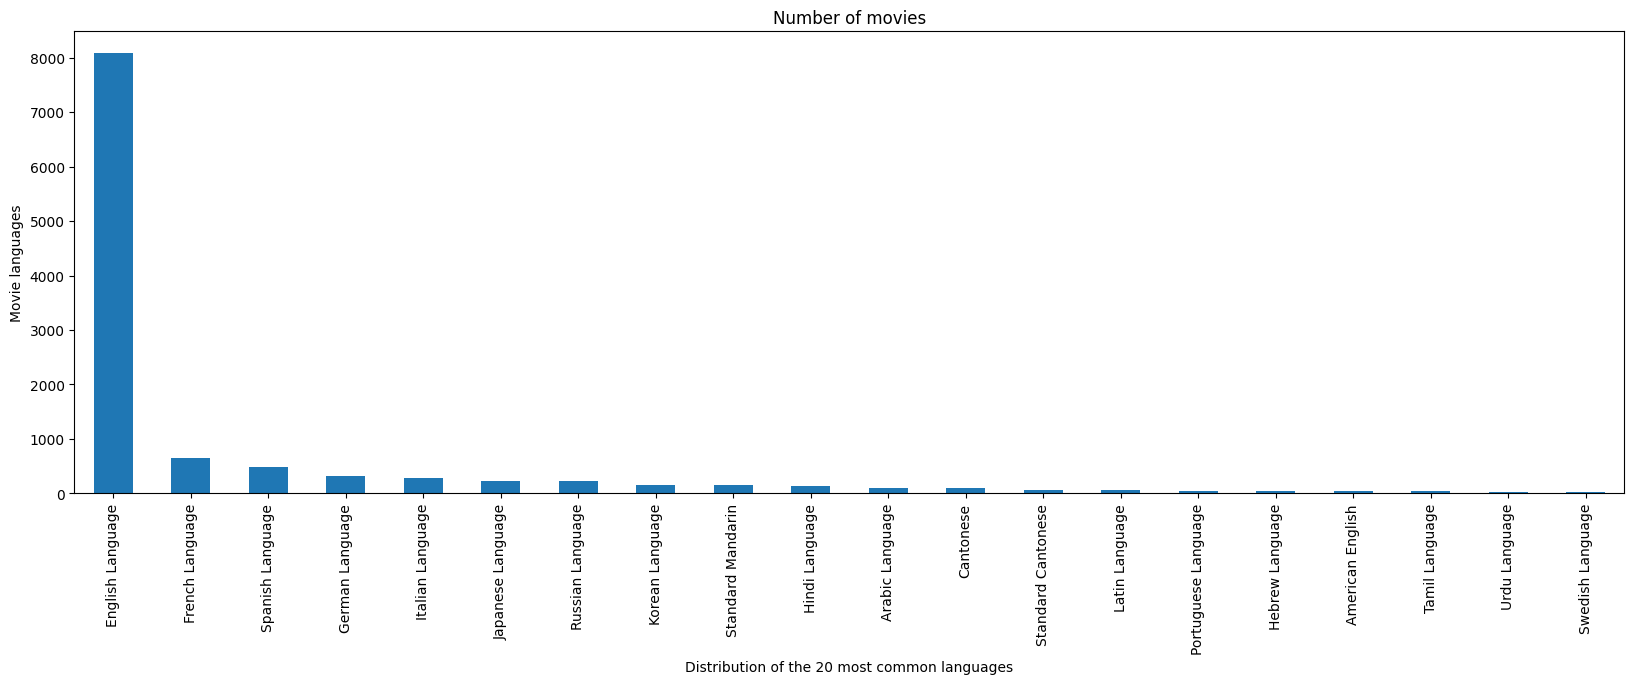

In [34]:
plot_top_20_most_popular(movies, 'Movie_languages','Distribution of the 20 most common languages','Movie languages','Number of movies')